# Poisson Distribution to PBHs

**References:**  [arXiv:1910.06077](https://arxiv.org/pdf/1910.06077.pdf), https://arxiv.org/pdf/1904.00984.pdf,
https://arxiv.org/pdf/1908.03596.pdf, https://arxiv.org/pdf/1805.03946.pdf, 
https://arxiv.org/pdf/0903.3184.pdf
https://arxiv.org/pdf/1803.00070.pdf  #lecture


**Misao Sasaki** [arXiv:1801.05235](https://arxiv.org/pdf/1801.05235.pdf)

**Celoria**  [arXiv:1807.11489](https://arxiv.org/pdf/1807.11489.pdf)


http://webcache.googleusercontent.com/search?q=cache:Jt8ib1chvdsJ:www.sapub.org/global/showpaperpdf.aspx%3Fdoi%3D10.5923/j.astronomy.20130201.02+&cd=13&hl=es-419&ct=clnk&gl=mx

###### Code Writed by Tadeo D.


In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import math
import seaborn as sns
from scipy import stats 
import csv
from scipy import constants
from tqdm import tqdm
from scipy.integrate import quad, dblquad
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const
import astropy.units as u
#from astropy.cosmology import WMAP9, z_at_value
import pandas as pd
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#pl.rcParams['figure.figsize'] = (16, 9)
#pl.style.use('ggplot')
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#
#from mlxtend.plotting import plot_linear_regression
from sympy import *

#### Read Data From LIGO DATABASE

In [2]:
df = pd.read_csv('LIGO_events')
#df.shape
#df.head()
#df.describe()
# Visualizamos rápidamente las caraterísticas de entrada
#df.drop(['id','version','GPS', 'mass_1_source_lower', 'mass_1_source_upper',
#         'mass_2_source_lower', 'mass_2_source_upper', 'network_matched_filter_snr',
#         'network_matched_filter_snr_lower', 'chirp_mass', 'redshift_lower', 'redshift_upper',
#         'far','far_lower','far_upper','final_mass_source_lower','final_mass_source_upper',
#         'chirp_mass_upper','chirp_mass_lower','reference','jsonurl','catalog.shortName','chirp_mass_source',
#         'chirp_mass_source_lower','chirp_mass_source_upper','network_matched_filter_snr_upper','luminosity_distance_lower',
#         'luminosity_distance_upper','chi_eff','chi_eff_lower','chi_eff_upper','total_mass_source_lower','total_mass_source_upper'],1).hist()
#pl.savefig('input_characteristics.png', dpi=300, bbox_inches='tight')
#pl.show()

### Functions to work

PBH binaries that are formed in the radiation dominated epoch continuously emit gravitational waves, gradually shrink, and finally merge. Since the initial orbital parameters of the binaries are stochastic, some binaries merge in the past, some other at present epoch, and the others in the future. According to Peters, a binary
consisting of point masses $m_{1}$ and $m_{2}$ with orbital parameter (a, e) merges due to gravitational
radiation after time **t** given by

$$t\, = \,\frac{15}{304}\frac{a^{4}}{G^{3}m_{1}m_{2}(m_{1} + m_{2})} \left[\frac{(1-e^{2})}{e^{\frac{12}{19}}} \left(1+\frac{121}{304}e^{2}\right)^{\frac{870}{2299}}\right]^{4} \int\limits_{0}^{e}de^{'}\frac{e^{'\frac{29}{19}}}{(1-e^{'2})^{-\frac{3}{2}}}\left(1 + \frac{121}{304}e^{'2}\right)^\frac{870}{2299}$$

When e \~ 1, the above formula can be simplified as:

$$ t = \frac{3}{85}\frac{1}{G^{3}m_{1}m_{2}(m_{1} + m_{2})}(1-e^{2})^{7/2}a^{4}$$

$H_{0} = 67.66\,\, km\, Mpc^{-1}\,s^{-1}$

$R_{s} = \frac{2GM}{c^{2}}$

In [16]:
H0 = cosmo.H(0)  #cosmo.H(0)  <Quantity 67.66 km / (Mpc s)>
G = const.G
c= const.c
z_r = 3500 #3450
z_eq = 3411
#rho_c0 = (3*(H0**2))/(8*math.pi*G)
rho_c0 = cosmo.critical_density0
Omega_DM = cosmo.Odm(z_r)


e_prim = np.arange(0.01,1.0,0.01)
#print(((1/H0)*3.08e+19*u.km/u.megaparsec).to(u.Gyr))
#e = [0.5,  0.2,  0.1,  0.05,  0.01] #Excentricity array of datas
#e = 0.1 #Half
a_s = 0.1*u.AU#Half Separation
separation = a_s.to(u.m)
#a = [0.001, 0.01, 0.1, 1, 7.63] #Separation in AU, the last one is 1pc = 208232 UA
#omega_m = 0.321


def F(e):
    return (e**(29.0/19.0)/((1-e**2)**(-1.5)))*(1 + (121/304)*(e**2.0))**(870/2299)
I, err = quad(F,0.0,0.99)#intregand 147

def t_merger(M1, M2, a, e):
    p1 = (15/304)*(((c**5)*a**4)/((G**3)*M1*M2*(M1+M2)))
    p2 = (((1-e**2)/e**(12/19))*(1+((121*e**2)/304))**(870/2299))**4
    t =  p1*p2
    return t
    

def t_merger1(M1,M2, a, e):
    t1 = (3/85)*((c**5)*((1-e**2)**(3.5))*(a**4))/((G**3)*M1*M2*(M1+M2))
    return t1

def Rs(M): #Schwarzschild radius equation
    R = 2*const.G*M/(const.c**2)
    return R


#def Z(D): #Redshift from Luminosity Distance
#    z = (H0/const.c)*D
#    return z




In [17]:
m1=24.5*const.M_sun
m2=18.3*const.M_sun


"""
e_value = []
#This "for" is to evaluate explicitly the integral of (147)
for j in e_prim:
    I, err = quad(F,0.0,j)
    e_value.append(I)
"""

print("integral result 0 --> 0.99:", I)
print("t_merger equation 147:",(t_merger(m1,m2,separation,0.99)*I).to(u.Gyr))
print("t_merger equation 148:",(t_merger1(m1,m2,separation,0.99)).to(u.Gyr))

integral result 0 --> 0.99: 0.1401096356448334
t_merger equation 147: 1.568779417533427e-07 Gyr
t_merger equation 148: 3.361967006079382e-06 Gyr


In [18]:
def F(e): #Celoria's Equation (2.13) 
    F = (1-e**2)**(-3.5)*(1 + (73/24)*e**2 + (37/96)*e**4)
    return F


def t_coal(M1, M2, a, F): #Celoria's Equation (2.17)
    t = (5/256)*(const.c**5/const.G**3)*(a**4)/((M1*M2*(M1 + M2)))*(1/F)
    return t
#return t #this variable has seconds unit

print((t_coal(m1,m2,separation,F(0.1))).to(u.Gyr))

1.567940044730308 Gyr


#### PBH Binary formation in the early Universe

$$ n = \frac{1}{vol} = \large{\mathscr{l}}\small{_{PBH}^{-3}}$$
$$ ñ = \frac{1}{vol}\left(\frac{1}{1+z_{r}}\right)^{3}$$

In [6]:
#M_pbh=1*(u.M_sun)
M_pbh = 1*const.M_sun
f_pbh = np.arange(0.01,0.99,0.1)


rH_h = c/cosmo.H(z_r)
rH_h.to(u.parsec)
vol_hzte = (rH_h)**3

rH_t = c/H0
rH_t.to(u.parsec)
vol_tot = (rH_t)**3

N_hztes = vol_tot/vol_hzte
M_hzte = (c**3/(2*G*cosmo.H(z_r)))
M_hzte.to(u.kg)
rho_tot = M_hzte/vol_hzte
rho_tot.to(u.kg/u.m**3)
rho_pbh = M_pbh/vol_hzte

def n(fpbh):
    n_pbh = (fpbh*Omega_DM*rho_tot)/M_pbh
    return n_pbh.to(1/u.parsec**3)

#f_pbh = rho_pbh/(rho_tot*Omega_DM)
#f_pbh.to(u.km/u.km) # 8.5759816×10−18
#n_pbh = (f_pbh*Omega_DM*rho_tot)/M_pbh
#n_pbh.to(1/u.parsec**3) #5.105725334786289e-14 1 / pc3

def ñ(n_pbh):
    ñ_pbh = n_pbh*(1/(1+z_r))**3
    return ñ_pbh

def l(fpbh):
    l_pbh = M_pbh**(1/3) * fpbh**(-1/3) * Omega_DM**(-1/3) * rho_tot**(-1/3)
    return l_pbh.to(u.parsec)

print("fpbh   nphb \t\t\t\t  ñpbh \t\t\t\t\t lpbh")
for i in f_pbh:
    print("%.2f" % i,"|", n(i),"\t ", ñ(n(i)),"\t", l(i))

fpbh   nphb 				  ñpbh 					 lpbh
0.01 | 59.535171196920686 1 / pc3 	  1.3873858937932249e-09 1 / pc3 	 0.25609953960631104 pc
0.11 | 654.8868831661275 1 / pc3 	  1.5261244831725472e-08 1 / pc3 	 0.11515370155168618 pc
0.21 | 1250.2385951353344 1 / pc3 	  2.9135103769657724e-08 1 / pc3 	 0.0928258709676598 pc
0.31 | 1845.5903071045416 1 / pc3 	  4.3008962707589976e-08 1 / pc3 	 0.0815245167475498 pc
0.41 | 2440.9420190737483 1 / pc3 	  5.688282164552222e-08 1 / pc3 	 0.07427012909948956 pc
0.51 | 3036.293731042955 1 / pc3 	  7.075668058345447e-08 1 / pc3 	 0.06905875411980285 pc
0.61 | 3631.6454430121626 1 / pc3 	  8.463053952138673e-08 1 / pc3 	 0.0650577220544308 pc
0.71 | 4226.99715498137 1 / pc3 	  9.850439845931899e-08 1 / pc3 	 0.06184757579393735 pc
0.81 | 4822.348866950576 1 / pc3 	  1.1237825739725122e-07 1 / pc3 	 0.059189834380680886 pc
0.91 | 5417.700578919783 1 / pc3 	  1.2625211633518347e-07 1 / pc3 	 0.05693705503332307 pc


x      z_dec
0.01 | 573105.6076411078
0.02 | 71637.32595513847
0.03 | 21225.170653374367
0.04 | 8953.790744392309
0.05 | 4583.85286112886


1.0907504363001746e-05 pc 1.617085967845929e-05 pc


3.946694914190309e-17 pc 1.4287693165725383e-16 pc


0.9999616138065506 0.9999787352755286


/home/thaddaios/.local/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


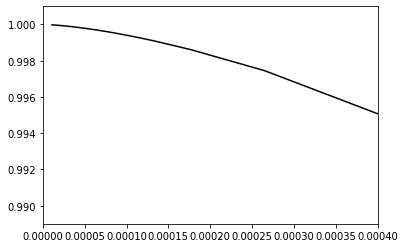

In [9]:
##############################################################################################
#If I evalue all functions at a mean_fpbh

suma = 0
for i in f_pbh:
    suma = suma + i
mean_fpbh = suma/len(f_pbh)
m_n_pbh = n(mean_fpbh)
m_ñ_pbh = ñ(n(mean_fpbh))
m_l_pbh = l(mean_fpbh)
#print("%.2f" % (mean_fpbh))

def x_max(z):
    return mean_fpbh**(1/3) * m_l_pbh * (1+z)
x_maxim = x_max(0)

def z_decopling(x):
    z_dec = (1+z_eq)*(x_maxim/x)**3 - 1
    return z_dec
#proponiendo x de tal manera que, x < x_maxim
# Entonces:
x_dec = np.arange(0.01,x_maxim.value,0.01)

#Usando el array de x_dec para calcular el z_decopling, obtenemos:
print("x      z_dec")
for i in x_dec:
    print(i,"|", z_decopling(i*u.parsec))

#para nuestra prueba, podemos tomar z_dec = 8953 con x_dec = 0.04 o bien, x_dec=0.5 con z_dec = 4583 el cual es mayor que z_rd

a = 0.05*u.parsec/(1 + 4583)
a_max = x_maxim / (1+z_eq)

a1 = ((rho_c0*Omega_DM)/((1+z_eq)*M_pbh))*((0.04*u.parsec)**4)
a1_max = ((rho_c0*Omega_DM)/((1+z_eq)*M_pbh))*(x_maxim**4)

print("\n")
print(a,a_max)
print("\n")
print(a1.to(u.parsec), a1_max.to(u.parsec))

def e_max(a):
    return (1 - (4*math.pi*m_ñ_pbh/3)**(2) * ((((1+z_eq)*M_pbh)/(rho_c0*Omega_DM))*a)**(3/2))**(1/2)
print("\n")
print(e_max(a_max), e_max(a))

z_step = np.linspace(4580,1)
a_array = []
for i in z_step:
    a_array.append(0.05*u.parsec/(1 + i))
   # print(e_max(0.05*u.parsec/(1 + i)))

pl.plot(a_array*(u.parsec), [e_max(0.05*u.parsec/(1 + i)) for i in z_step], color='k', linestyle='solid')
pl.ylim(0.989,1.001)
pl.xlim(0,0.0004)
pl.show()

# -------------------------------------------------------------------------------------------
#### Equation 140 Sasaki
$$dP = \frac{4\pi^{2}}{3}n_{pbh}^{1/2}(1+z_{eq})^{3/2}f_{pbh}^{3/2}a^{1/2}e(1-e^{2})^{-3/2}dade$$


In [15]:
def integrand_dP(a,e):
    return a**(1/2) * e*(1 - e**(2))**(-3/2)

I, err = dblquad(integrand_dP, 0.0, a_max.value, lambda e: 0.0, lambda e:1.0)

P = I * (4/3)*math.pi**(2) * m_ñ_pbh**(1/2) * (1+z_eq)**(3/2) * mean_fpbh**(3/2) * (u.parsec**(3/2))

print(P)


1.801822249249955e-08


In [137]:
#It's a example section to prove a bit algorithm from Poisson Distribution
#You doesn't pay attention

np.random.seed(2000) # replicar random

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

mu =  3.6 # parametro de forma 
poisson = stats.poisson(mu) # Distribución
x = np.arange(poisson.ppf(0.01), poisson.ppf(0.99))
fmp = poisson.pmf(x) # Función de Masa de Probabilidad
#pl.plot(x, fmp, '--')
#pl.vlines(x, 0, fmp, colors='b', lw=5, alpha=0.5)
#pl.title('Distribución Poisson Ejemplo')
#pl.ylabel('probabilidad')
#pl.xlabel('valores')
#pl.show()